## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
core_used = 24
normalised = True
save_model = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False
rngs = list(range(100)) # for stable rng, for pure random, a random set can be used

In [4]:
# dynamic_data_code = 'fgfr4_ccle_dynamic_features_v2'
# drug_code = 'gdsc-1-FGFR_0939'
# match_rules_data_code = 'fgfr4_model_ccle_match_rules'
# folder_name = "FGFR4-combined-model-training"
# exp_id = "fgfr4_v4"  # experiment id, fgfr4_v1, cdk46_v1

In [5]:
dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
drug_code = 'gdsc-2-Palbociclib'
match_rules_data_code = 'cdk_model_match_rules'
folder_name = "CDK46-combined-model-training"
exp_id = "cdk46_v4" # experiment id, fgfr4_v1, cdk46_v1

In [6]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

Data loaded for code generic-gdsc-2-Palbociclib-LN_IC50-cdk46_ccle_dynamic_features_v3-true-Unnamed: 0 Feature Shape (584, 590) Label Shape (584,)
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50 Feature Shape (584, 19221) Label Shape (584,)


In [7]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [9]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(584, 19221)
(584,)


In [10]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [11]:
combined_feature_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,CDK2ccCYCEccP27p_auc,CDK2ccCYCEccP27p_median,CDK2ccCYCEccP27p_tfc,CDK2ccCYCEccP27p_tmax,CDK2ccCYCEccP27p_max,CDK2ccCYCEccP27p_tmin,CDK2ccCYCEccP27p_min,CDK2ccCYCEccP27p_ttsv,CDK2ccCYCEccP27p_tsv,CDK2ccCYCEccP27p_init
SIDM00872,5.296090,0.000000,6.794416,3.452859,5.260778,0.042644,4.339137,5.833143,7.313246,4.764474,...,0.004366,0.004577,0.605010,0.967742,0.004583,0.0,0.002856,0.032258,0.002856,0.002856
SIDM00866,5.214125,0.000000,6.328047,3.168321,4.654206,0.042644,0.432959,6.574102,5.140779,5.114783,...,0.004215,0.004457,1.130657,0.967742,0.004466,0.0,0.002096,0.032258,0.002096,0.002096
SIDM00885,5.241840,0.201634,5.615299,3.090853,3.732269,0.084064,0.111031,4.026800,5.471513,6.019480,...,0.004297,0.004550,0.989570,0.967742,0.004551,0.0,0.002288,0.032258,0.002288,0.002288
SIDM00884,3.481557,0.000000,7.070389,2.341986,3.679199,0.176323,3.420887,5.854494,5.976134,5.112283,...,0.004537,0.004764,0.350453,0.967742,0.004774,0.0,0.003535,0.032258,0.003535,0.003535
SIDM00874,4.903038,0.000000,7.177719,2.744161,4.648465,0.150560,0.070389,5.819924,4.374344,3.814550,...,0.004449,0.004674,0.639426,0.967742,0.004685,0.0,0.002858,0.032258,0.002858,0.002858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00741,5.054848,0.000000,6.229588,2.805292,4.458776,0.189034,0.028569,0.650765,3.883621,5.510012,...,0.003852,0.004156,1.026422,0.967742,0.004186,0.0,0.002066,0.032258,0.002066,0.002066
SIDM00760,5.282810,0.000000,6.273516,3.090853,5.070389,0.310340,0.124328,2.950468,3.889474,5.275380,...,0.003763,0.004073,1.328825,0.967742,0.004097,0.0,0.001759,0.032258,0.001759,0.001759
SIDM00273,4.631104,0.000000,6.685940,2.739848,4.545968,0.028569,1.007196,6.046797,4.066950,4.890447,...,0.004359,0.004593,2.175721,0.967742,0.004600,0.0,0.001449,0.032258,0.001449,0.001449
SIDM00560,5.127221,0.000000,7.304146,1.782409,4.192983,0.137504,0.189034,6.446422,4.791814,3.723559,...,0.004616,0.004870,0.681136,0.967742,0.004884,0.0,0.002905,0.032258,0.002905,0.002905


In [12]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, 
              normalised=False,
              save_model=False, 
              **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    returned_data = {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

#### custom pipelines

In [13]:
def pipeline_select_genes_only(X_train, y_train, rng, model_used, keep_features, normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    dynamic_X_train = X_train[final_selected_features]
    static_X_train = X_train.drop(final_selected_features, axis=1)
    k = X_train.shape[1]
    if k > 500:
        k = 500  # limit the number of features to 500
    selected_features, scores = f_regression_select(static_X_train, y_train, k)
    for f in selected_features:
        final_selected_features.append(f)
    selected_X_train = X_train[final_selected_features]
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [14]:
def pipeline_select_only(X_train, y_train, rng, model_used, 
                                     keep_features, limit_features = False, 
                         normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    selected_X_train = X_train[final_selected_features]
    # get the scores for the selected features using f_regression
    k = selected_X_train.shape[1]
    if limit_features:
        if k > 500:
            k = 500  # limit the number of features to 500
    _, scores = f_regression_select(selected_X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [15]:
transformed_gene_list = [] 
# we deduce these from the original match rules file

gene_match_rules = match_rules.dropna(subset=['reference'])
for index, row in gene_match_rules.iterrows():
    gene = row['reference'].split(';')
    for g in gene:
        if g not in transformed_gene_list:
            transformed_gene_list.append(g)    
            
dynamic_features = list(dynamic_feature_data.columns)
transformed_dynamic_features = []
for f in dynamic_features:
    transformed_dynamic_features.append(f)
for g in transformed_gene_list:
    if g not in transformed_dynamic_features:
        transformed_dynamic_features.append(g)
        
print(f'Length of transformed gene features: {len(transformed_gene_list)}')
print(f'Length of transformed dynamic features: {len(transformed_dynamic_features)}')

Length of transformed gene features: 39
Length of transformed dynamic features: 629


## Analysis

In [16]:
import pickle
exp_id = 'cdk46_v4'
experiments = ['control_dynamic',
               'specie_genes', 'specie_genes_dynamic',
               'select_gene_dynamic']


model_used = "RandomForestRegressor"

df_list_total = []
for exp in experiments:
    df_list = []
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
    print(f'Loaded {model_used} for {exp}')
    df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)

total_df = pd.concat(df_list_total, axis=0)
# total_df

Loaded RandomForestRegressor for control_dynamic
Loaded RandomForestRegressor for specie_genes
Loaded RandomForestRegressor for specie_genes_dynamic
Loaded RandomForestRegressor for select_gene_dynamic


,rng,condition,model_performance,p_vals,feature_importance,model,experiment
0,0,RandomForestRegressor,0.404697,1.476658e-03,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
1,1,RandomForestRegressor,0.398128,1.791080e-03,"([INSR_auc, INSR_median, INSR_tmax, INSR_max, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
2,2,RandomForestRegressor,0.470806,1.677678e-04,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
3,3,RandomForestRegressor,0.572727,2.137378e-06,"([INSR_auc, INSR_median, INSR_max, INSR_tmin, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
4,4,RandomForestRegressor,0.331200,1.039727e-02,"([INSR_auc, INSR_median, INSR_tfc, INSR_max, I...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
...,...,...,...,...,...,...,...
95,95,RandomForestRegressor,0.392404,2.112544e-03,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
96,96,RandomForestRegressor,0.508030,3.999714e-05,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
97,97,RandomForestRegressor,0.546582,7.514893e-06,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
98,98,RandomForestRegressor,0.594493,6.887507e-07,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic


In [17]:
# for each model, create a dataframe with the feature importance of all features 

all_new_feat_imp = []
for index, row in total_df.iterrows():
    model = row['model']
    # print(model, row['condition'], row['rng'], row['experiment'])
    importances = model.feature_importances_.tolist()
    feature_names = row['feature_importance'][0]
    # make index a repeat of index over the number of features
    feat_imp = (feature_names, importances)
    all_new_feat_imp.append(feat_imp)
    
total_df.insert(4, 'tree_feature_importance', all_new_feat_imp)
    

In [113]:
powerkit = Powerkit(new_feature_data, new_label_data)
exp_condition = 'select_gene_dynamic'
# rename the 'experiment' column to 'condition' and 'condition' to 'model_name' 
total_df['model_name'] = total_df['condition']
total_df['condition'] = total_df['experiment']
mean_contribution = powerkit.get_mean_contribution(total_df, 
                                                   exp_condition, 
                                                   'tree_feature_importance', 
                                                   strict_mean=0.75)
mean_variation = get_variation(total_df, exp_condition, 
                               col_name='tree_feature_importance', 
                               use_iqr=False)

In [114]:
mean_contribution.shape

(1024, 3)

In [115]:
mean_variation.shape

(1024, 4)

In [116]:
# join the two dataframes
mean_df = mean_contribution.join(mean_variation, rsuffix='_variation')

In [117]:
mean_df.head(10)

,iteration_no,scores,count,variability_score,std,mean,count_variation
feature_names,,,,,,,
WAS,49.500000,0.064567,100,0.491256,0.031719,0.064567,100
TJP1,49.500000,0.064156,100,0.444885,0.028542,0.064156,100
PXDC1,49.500000,0.032864,100,0.488160,0.016043,0.032864,100
BCL2L1,49.755102,0.021955,98,0.273716,0.006009,0.021955,98
RPL3,49.500000,0.021264,100,0.438694,0.009328,0.021264,100
PPIC,49.500000,0.017414,100,0.622843,0.010846,0.017414,100
LAMA5,49.500000,0.014887,100,0.369109,0.005495,0.014887,100
CAP2,49.500000,0.011687,100,0.771764,0.009019,0.011687,100
CCN1,49.500000,0.010582,100,0.812460,0.008598,0.010582,100


In [118]:
import seaborn as sns
condition_df = total_df[total_df['condition'] == exp_condition]
data = condition_df['tree_feature_importance']

# extract the feature names and scores from the feature importance column
feature_names = []
scores = []

for row in data:
    feature_names.append(row[0])
    scores.append(row[1])

print(len(feature_names), len(scores))

feature_names_all = []
scores_all = []

for feature_name, score in zip(feature_names, scores):
    for feature, score in zip(feature_name, score):
        feature_names_all.append(feature)
        scores_all.append(score)

print(len(feature_names_all), len(scores_all))

# create a dataframe from the feature names and scores
df = pd.DataFrame({'feature_names': feature_names_all, 'scores': scores_all})

df.head()


100 100
109000 109000


,feature_names,scores
0,INSR_auc,0.000043
1,INSR_median,0.000073
2,INSR_tfc,0.000278
3,INSR_tmax,0.000000
4,INSR_max,0.000090


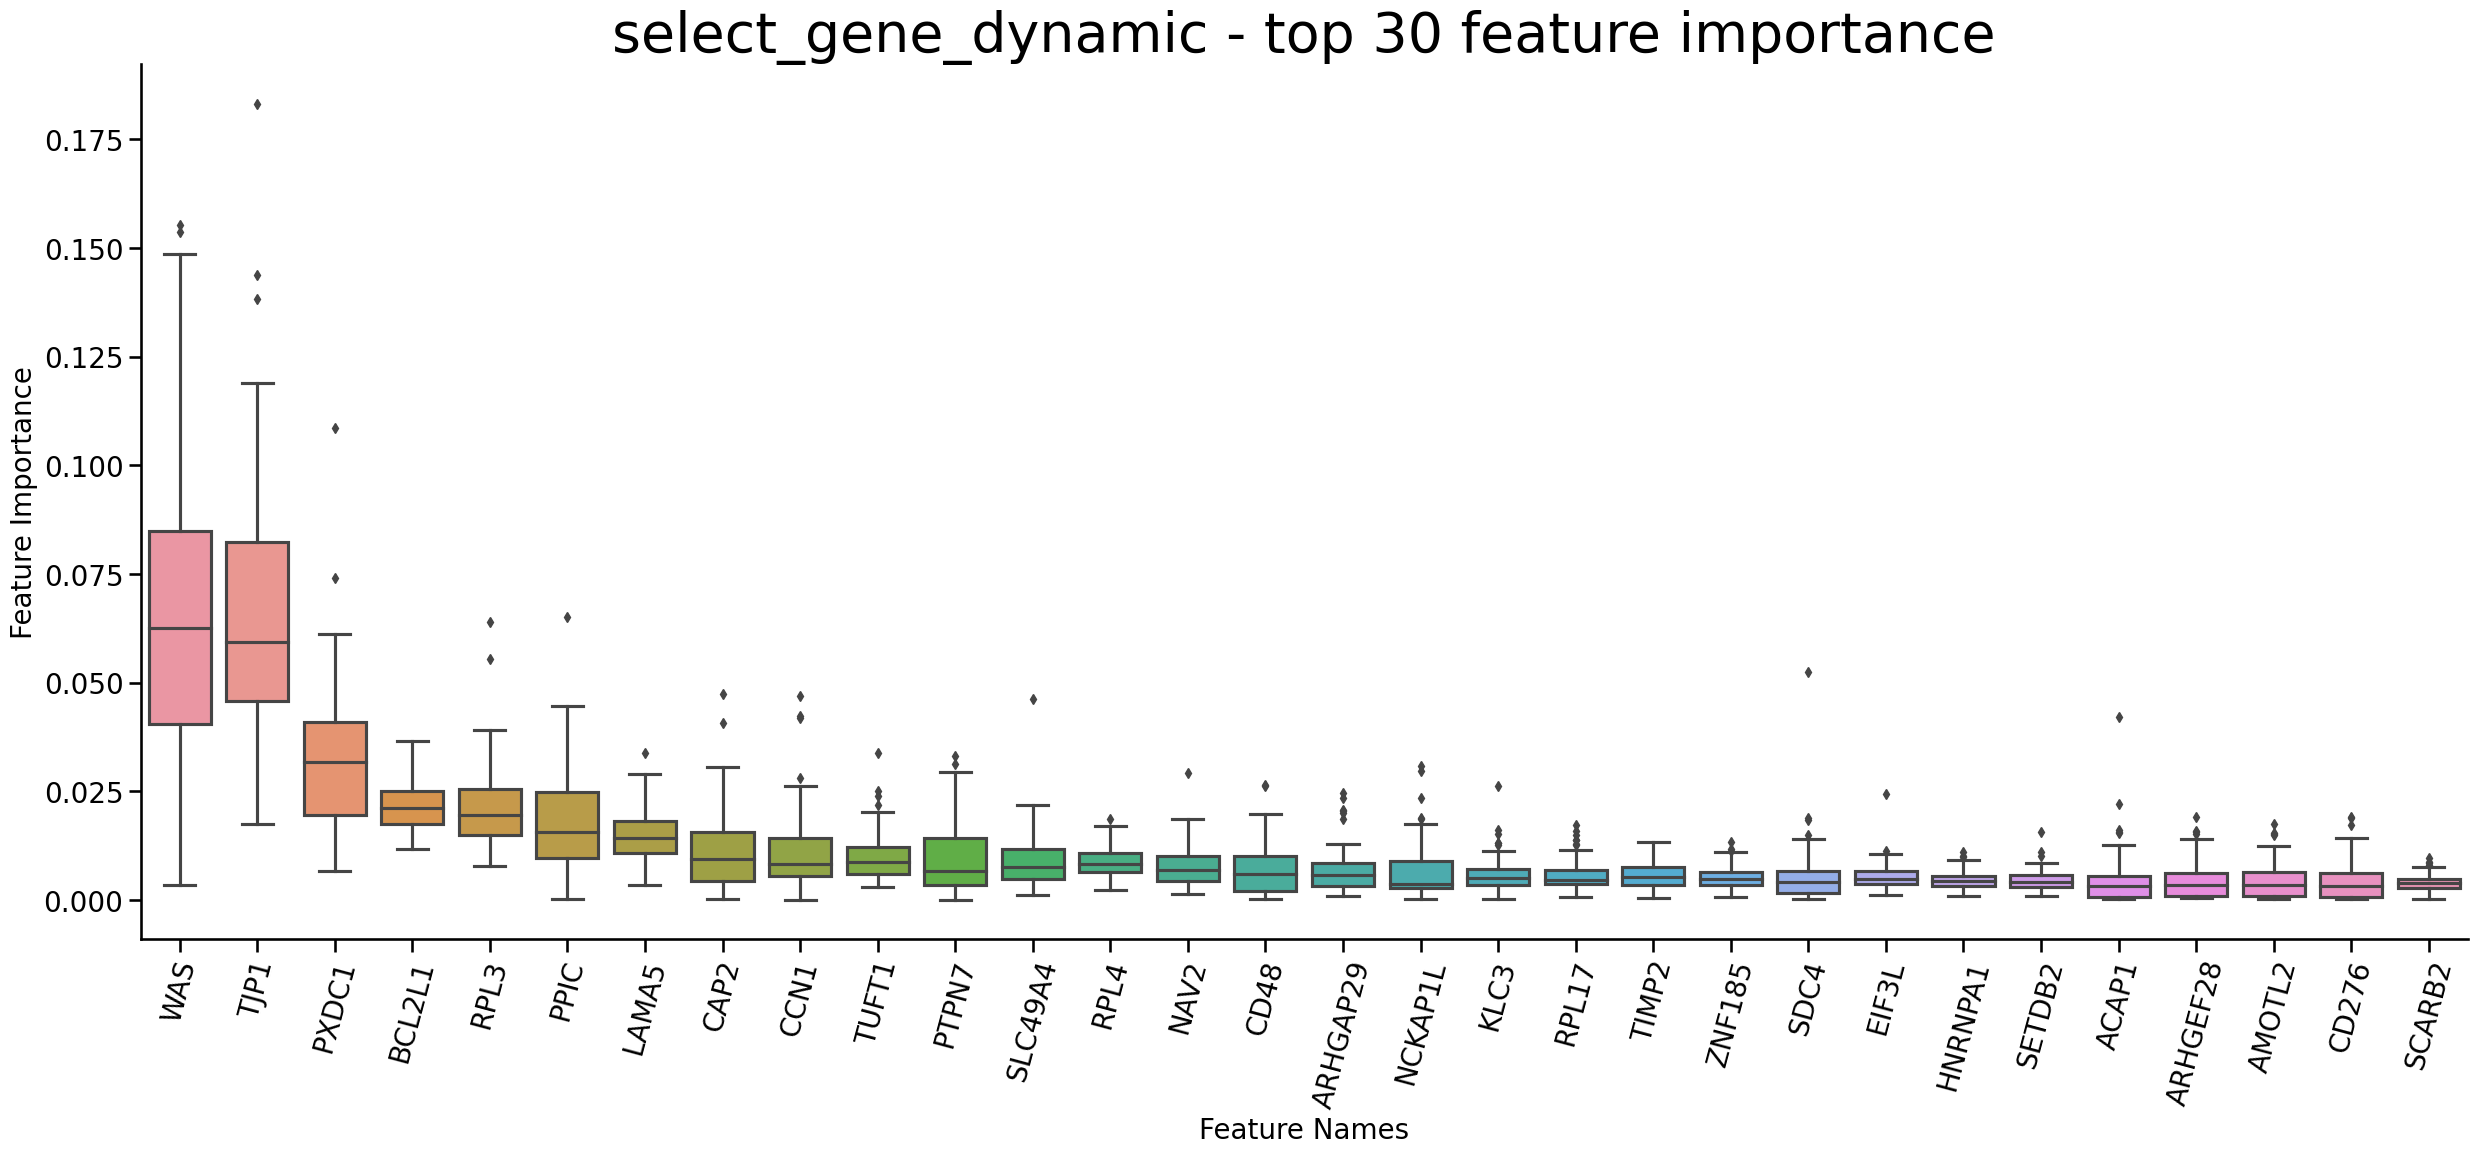

In [119]:
features_to_include = mean_df.index[:30]

# filter the dataframe by the features to include
filtered_df = df[df['feature_names'].isin(features_to_include)]

plot_order = filtered_df.groupby('feature_names').mean().sort_values('scores', ascending=False).index

sns.set_context('talk')

# plot the boxplot
sns.catplot(x='feature_names', y='scores', data=filtered_df, kind='box', height=10, aspect=2.5, order=plot_order)

# enlarge the x axis labels and y axis labels
plt.xlabel('Feature Names', fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.title(f'{exp_condition} - top 30 feature importance', fontsize=40)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)
plt.show()